In [1]:
#!/usr/bin/env python

# import libraries
import pandas as pd
import networkx as nx
from random import randint as rand
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
data_path_lewis = '../data/processed/mslewis_business_small.gml'
data_path_cq = '../data/processed/cashquestions_10k.gml'
data_path_ao = '../data/processed/andrew_oxlade_10k.gml'
data_path_hd = '../data/processed/haggerdoo_10k.gml'

In [2]:
# read in gml
graph_cq = nx.read_gml(data_path_cq)
graph_lewis = nx.read_gml(data_path_lewis)
graph_ao = nx.read_gml(data_path_ao)
graph_hd = nx.read_gml(data_path_hd)

In [16]:
def network_stats(graph):
    """
    Network stats for graph
    """
    # betweeness centrality
    bc = nx.betweenness_centrality(graph)
    print(sorted(bc, key=bc.get, reverse=True)[:20])
    nx.set_node_attributes(graph, name='bc', values=bc)

    # degree centrality
    dc = nx.degree_centrality(graph)
    print(sorted(dc, key=dc.get, reverse=True)[:20])
    nx.set_node_attributes(graph, name='dc', values=dc)

    # in degree centrality
    idc = nx.in_degree_centrality(graph)
    print(sorted(idc, key=idc.get, reverse=True)[:20])
    nx.set_node_attributes(graph, name='idc', values=idc)

    # out degree centrality
    odc = nx.out_degree_centrality(graph)
    print(sorted(odc, key=odc.get, reverse=True)[:20])
    nx.set_node_attributes(graph, name='odc', values=odc)

    # page rank
    pr = nx.pagerank(graph)
    print(sorted(pr, key=pr.get, reverse=True)[:20])
    nx.set_node_attributes(graph, name='pr', values=pr)
    
    # eigen vector
    edc = nx.eigenvector_centrality(graph)
    print(sorted(edc, key=edc.get, reverse=True)[:20])
    nx.set_node_attributes(graph, name='edc', values=edc)
    
    return graph

In [17]:
ml_list = network_stats(graph_lewis)
cq_list = network_stats(graph_cq)
ao_list = network_stats(graph_ao)
hd_list = network_stats(graph_hd)

['taraevans', 'DanPlant', 'HelenKnapman', 'leahmilner', 'andrew_oxlade', 'stevenowottny', 'gompertz', 'archieluthra', 'MSE_GuyAnker', 'RichardJLloyd', 'KatieMorley_', 'financialombuds', 'lovemoney_com', 'fairerfinance', 'hilaryosborne', 'helen_undy', 'samdunn1972', 'itvMLshow', 'Ruth_Emery', 'natdebtline']
['taraevans', 'andrew_oxlade', 'leahmilner', 'fairerfinance', 'stevenowottny', 'HelenKnapman', 'Ruth_Emery', 'Harriet_Meyer', 'MSE_GuyAnker', 'DanPlant', 'KatieMorley_', 'lovemoney_com', 'gompertz', 'VBischoff', 'hilaryosborne', 'clareefrancis', 'JohnTheJourno', 'PensionsMonkey', 'RichardJLloyd', 'financialombuds']
['gompertz', 'taraevans', 'andrew_oxlade', 'pcollinson', 'leahmilner', 'PensionsMonkey', 'jimconey', 'VBischoff', 'Harriet_Meyer', 'rosaltmann', 'MSE_GuyAnker', 'hilaryosborne', 'samdunn1972', 'clareefrancis', 'lisabachelor', 'andrewellson', 'emmalunn', 'fairerfinance', 'Ruth_Emery', 'RichardJLloyd']
['taraevans', 'stevenowottny', 'HelenKnapman', 'lovemoney_com', 'fairerfi

In [10]:
list(set(hd_list).intersection(ml_list).intersection(ao_list))

['DanielJonesSun',
 'jillinsley',
 'MSE_GuyAnker',
 'andyverity',
 'lisabachelor',
 'ukmoneyguru',
 'JoGornitzki',
 'VBischoff',
 'AdamShawBiz',
 'Harriet_Meyer',
 'SarahModlock',
 'gompertz',
 'HelenKnapman']

In [ ]:
# key actor analysis
# betweeness vs page rank 

data_ml = pd.DataFrame.from_dict(dict(graph_lewis.nodes(data=True)), orient='index')
data_ao = pd.DataFrame.from_dict(dict(graph_ao.nodes(data=True)), orient='index')
data_hd = pd.DataFrame.from_dict(dict(graph_hd.nodes(data=True)), orient='index')
data_cq = pd.DataFrame.from_dict(dict(graph_cq.nodes(data=True)), orient='index')
data_cq.drop(['CashQuestions'], inplace=True)

In [12]:
data_cq['handle'] = data_cq.index
data_ml['handle'] = data_ml.index
data_ao['handle'] = data_ao.index
data_hd['handle'] = data_hd.index

In [13]:
data_cq[['statuses','friends', 'followers', 'listed', 'ffr', 'lfr']] = data_cq[['statuses','friends', 'followers', 'listed', 'ffr', 'lfr']].apply(pd.to_numeric)
data_ml[['statuses','friends', 'followers', 'listed', 'ffr', 'lfr']] = data_ml[['statuses','friends', 'followers', 'listed', 'ffr', 'lfr']].apply(pd.to_numeric)
data_ao[['statuses','friends', 'followers', 'listed', 'ffr', 'lfr']] = data_ao[['statuses','friends', 'followers', 'listed', 'ffr', 'lfr']].apply(pd.to_numeric)
data_hd[['statuses','friends', 'followers', 'listed', 'ffr', 'lfr']] = data_hd[['statuses','friends', 'followers', 'listed', 'ffr', 'lfr']].apply(pd.to_numeric)

In [19]:
# pr vs betweeness
def plot_actor_analysis(data):
    sns.set(style="whitegrid")
    f, ax = plt.subplots(figsize=(12, 12))
    sns.despine(f, left=True, bottom=True)
    sns.scatterplot(data=data,
                    x="bc", y="pr",
                    size="statuses",
                    palette="ch:r=-.2,d=.3_r",
                    sizes=(1, 400), linewidth=0,
                    ax=ax, legend=False)
    plt.title('Key Actor Analysis', fontsize=20)
    # Set x-axis label
    plt.xlabel('Betweeness Centrality')
    # Set y-axis label
    plt.ylabel('Pagerank')

    def label_point(x, y, val, ax):
            a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
            for i, point in a.iterrows():
                ax.text(point['x']+.0002, point['y'], str(point['val']))
    label_point(data.bc, data.pr, data.handle, plt.gca())

ValueError: Could not interpret input 'pr'

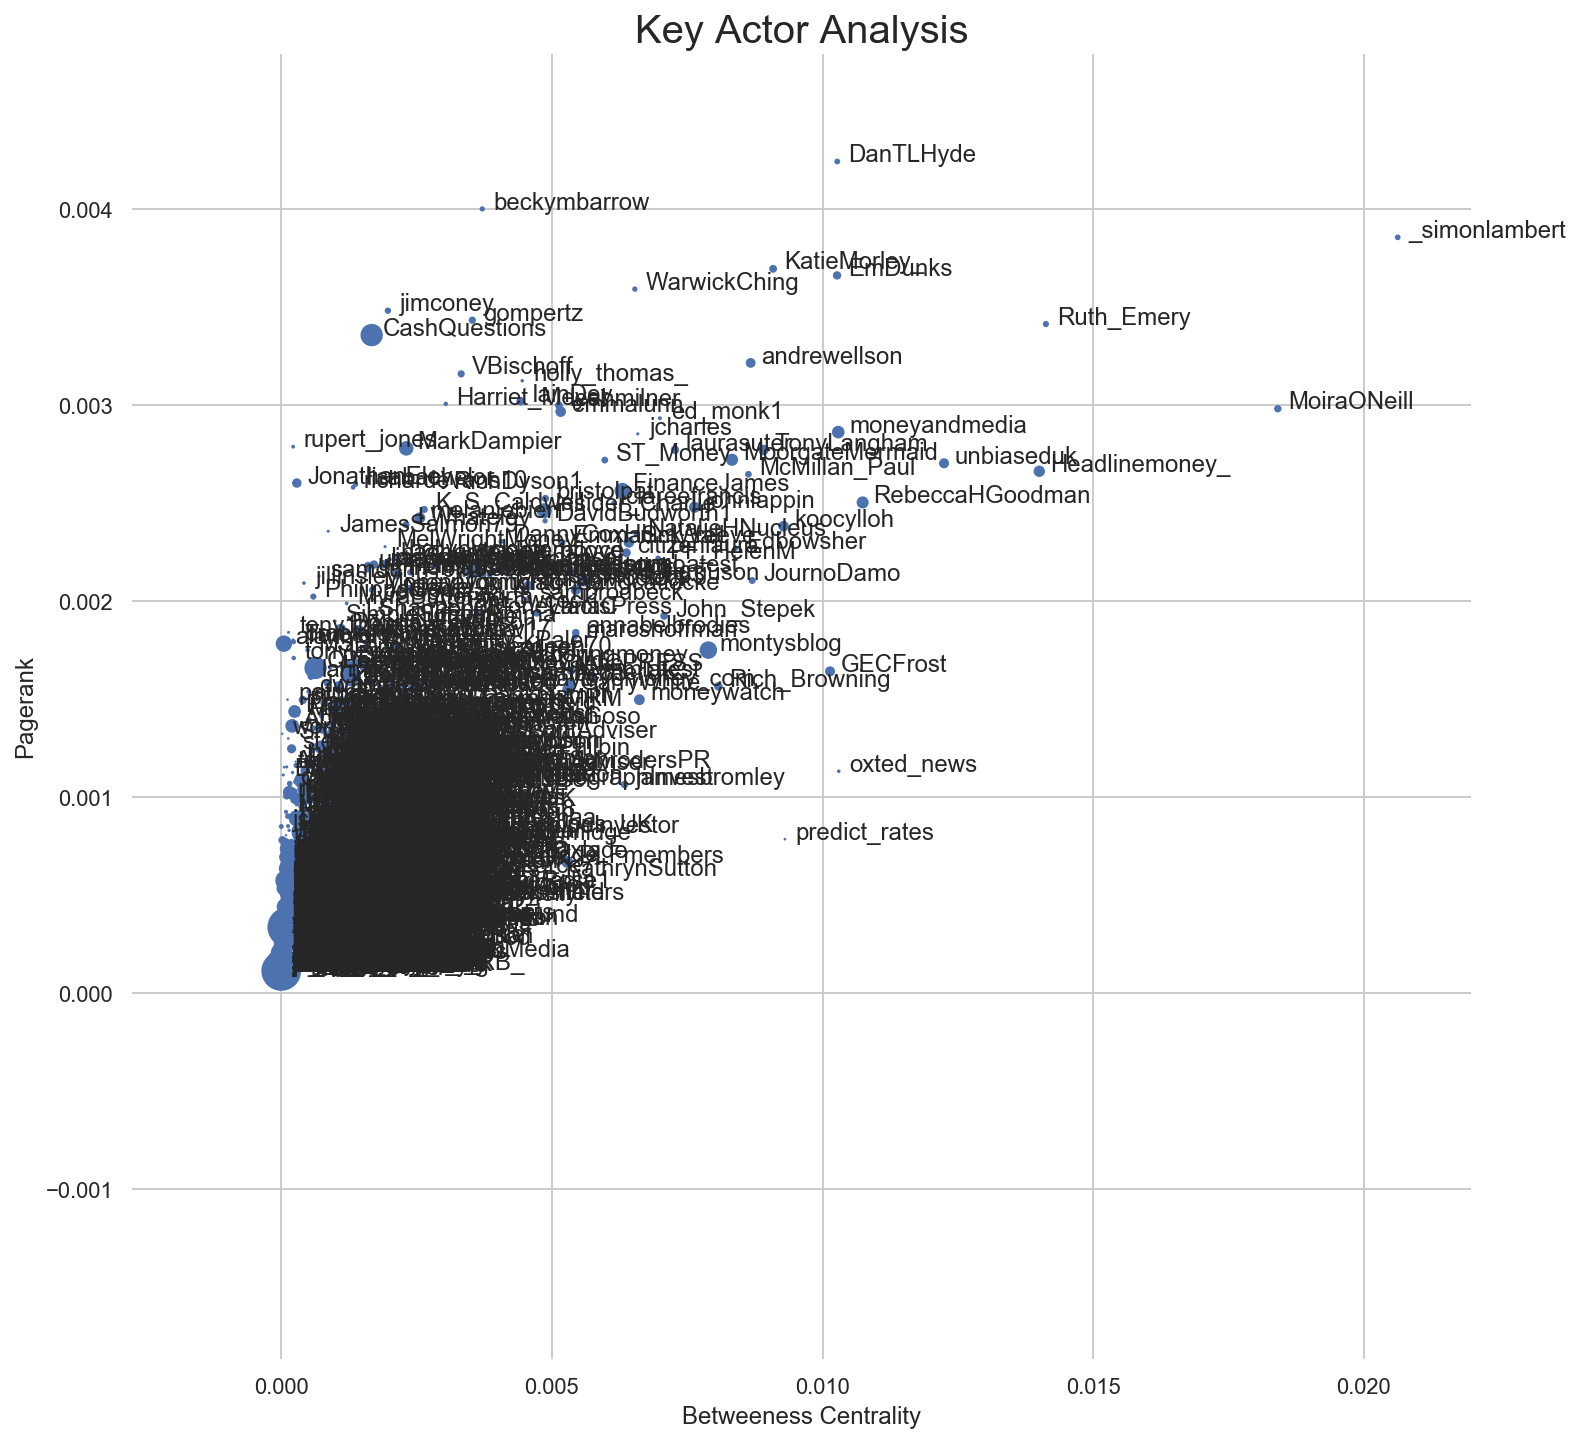

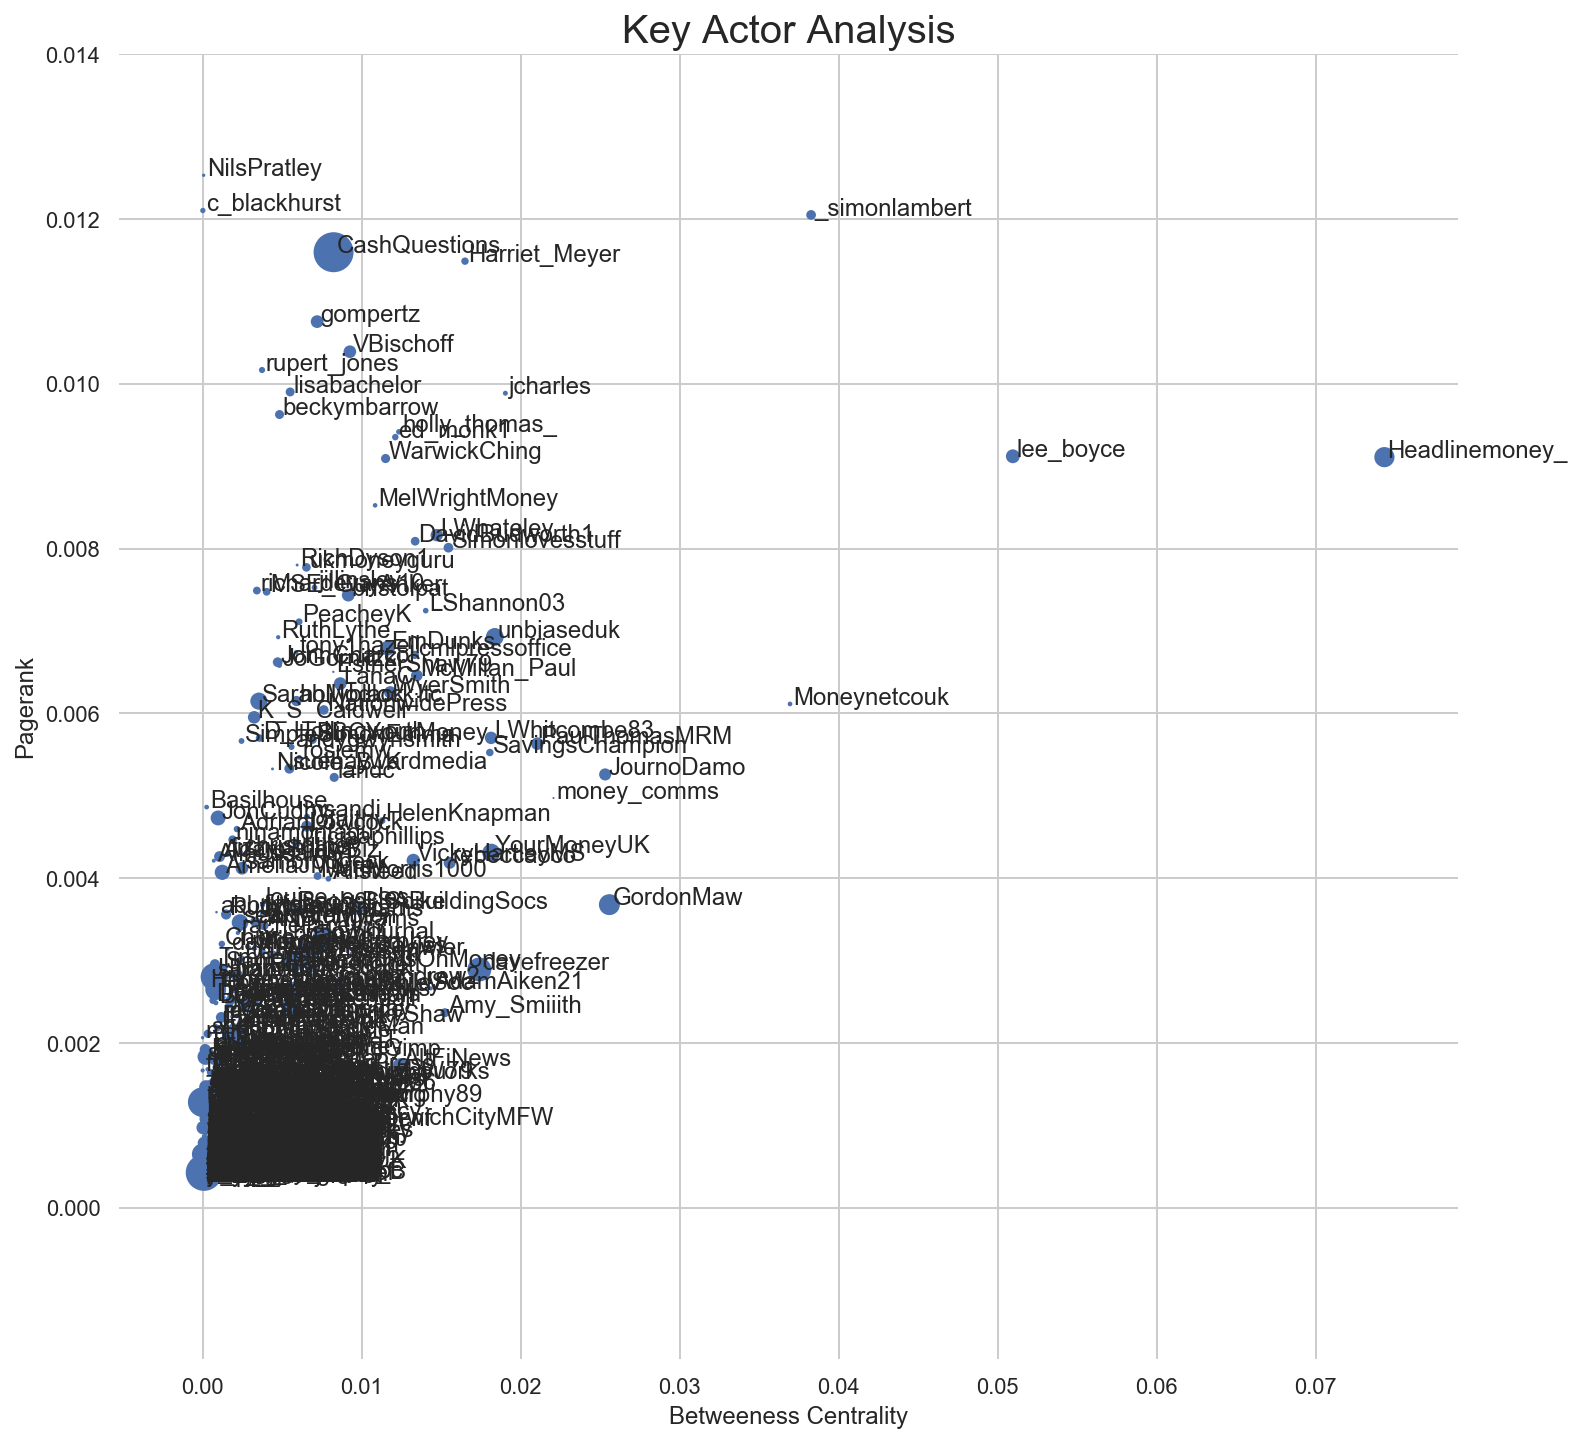

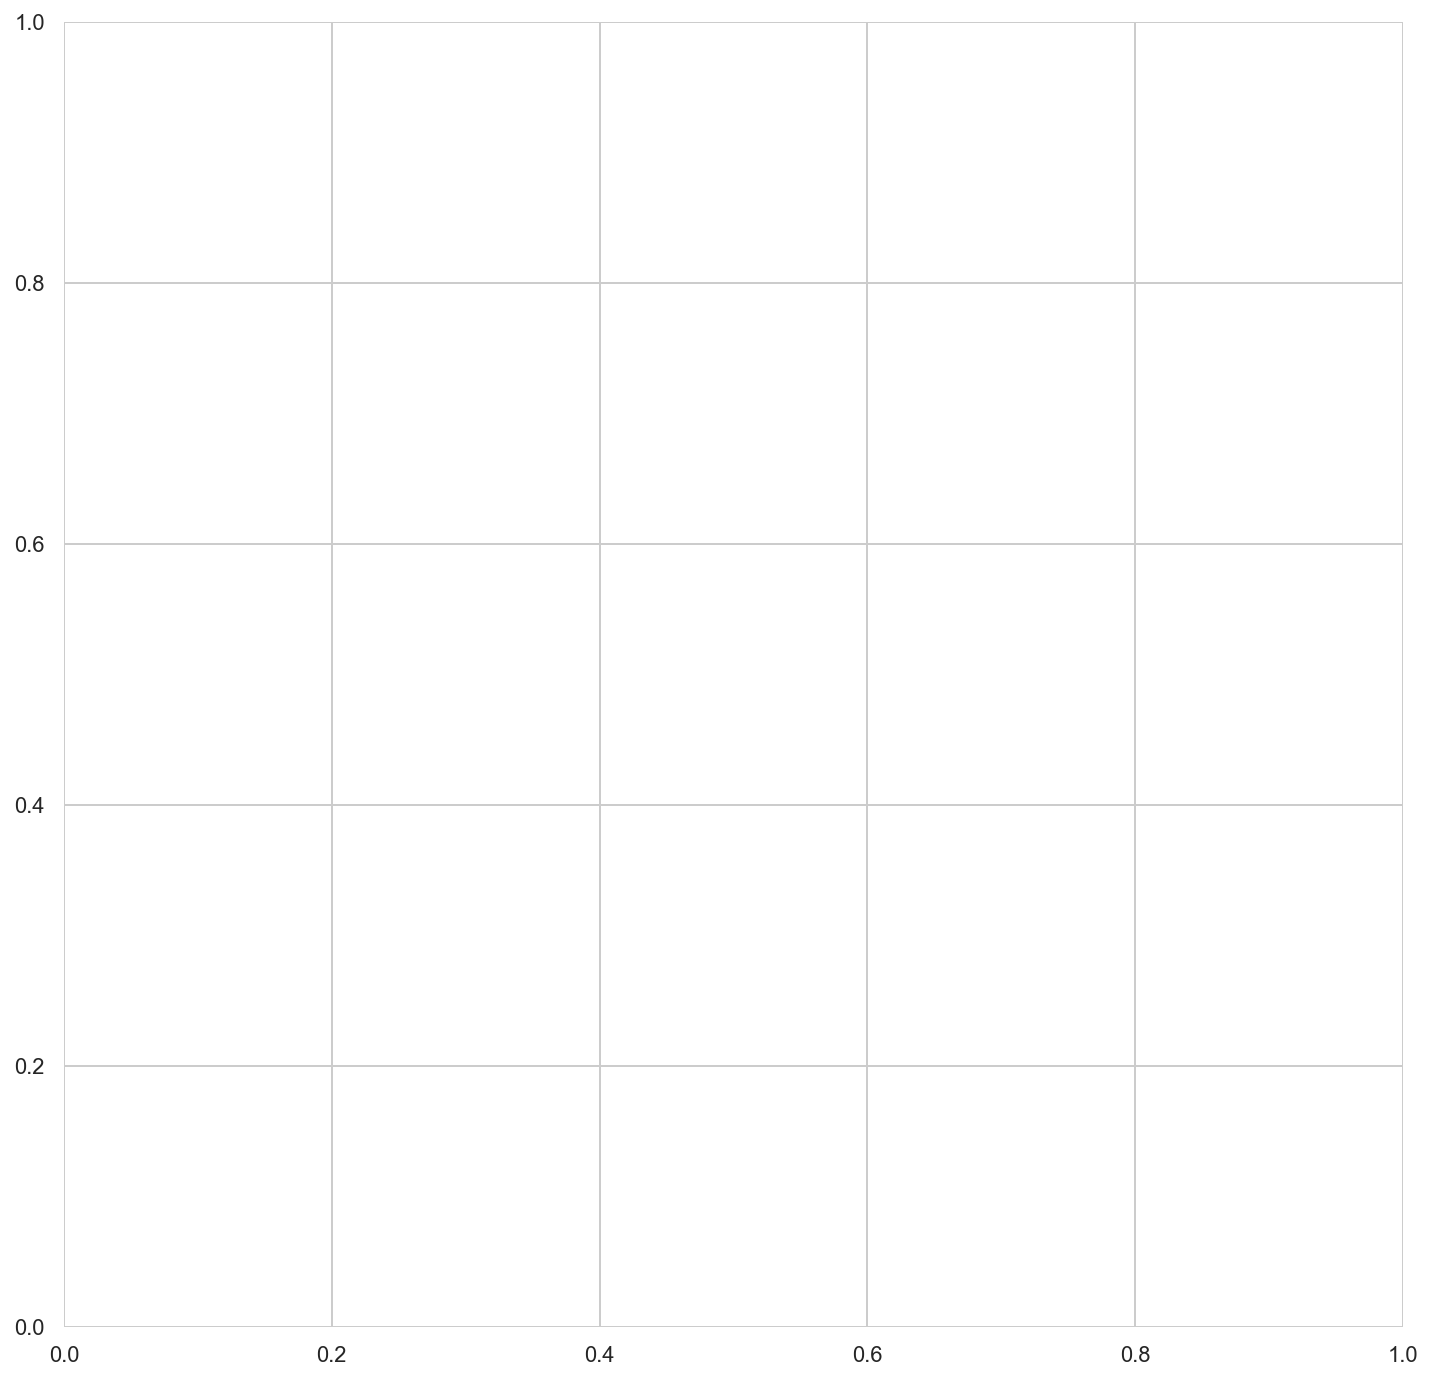

In [20]:
plot_actor_analysis(data_ao)
plot_actor_analysis(data_hd)
plot_actor_analysis(data_ml)
plot_actor_analysis(data_cq)